# Data Preparation

In [102]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [103]:
df = pd.read_csv("C:/Users/andy/Downloads/Data_Analyst_(ID)_Data_set.csv")

# Exploratory data analysis 

Description of file:
    
Id: id of the document

doc_type: the filetype of the document

Extractor: the entity that extracted data from the document. Whether it was a human or a model

Amount: the amount prediction made by our machine learning model for this document

Amount_label: human validated value for the amount of this document

Bill_date: the bill_date prediction output by our model

Bill_date_label: human validated value for bill_date

Vendor: vendor prediction made by our model

Vendor_label: human validated value for vendor

Vendor_score: how confident the extractor is in the vendor prediction, ranges from 0.0 to 1.0

Invoice_number: invoice number prediction made by model

Invoide_number_label: human validated value for invoice number

In [104]:
df.head()

,id,doc_type,extractor,amount,amount_label,vendor,vendor_score,vendor_label,invoice_number,invoice_number_label,bill_date,bill_date_label
0,52389374,pdf,model,581.70,581.70,NaN,NaN,Customer 7,1d98332cd1,6161d7fa27,22.08.2018,2018-08-22 00:00:00
1,51273675,pdf,model,NaN,152.55,camscanner,0.636422,Pickering Auto Lab,NaN,NaN,08/03/2018,2018-08-03 00:00:00
2,52564036,png,model,193.78,193.78,orientaltrading,0.695752,Oriental Trading,4d723cddbd,NaN,07/26/18,2018-07-26 00:00:00
3,52835653,png,model,7.00,7.00,bwc.ohio.gov,0.577856,bwc,NaN,NaN,08/06/2018,2018-08-06 00:00:00
4,52682559,pdf,human,16.33,12.02,cheritzplus,0.850405,Cheritzplus,9c0849c706,9c0849c706,NaN,2017-08-11 00:00:00


In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14830 entries, 0 to 14829
Data columns (total 12 columns):
id                      14830 non-null int64
doc_type                14830 non-null object
extractor               14830 non-null object
amount                  13767 non-null float64
amount_label            14830 non-null float64
vendor                  14175 non-null object
vendor_score            14175 non-null float64
vendor_label            14830 non-null object
invoice_number          10778 non-null object
invoice_number_label    10696 non-null object
bill_date               13909 non-null object
bill_date_label         14830 non-null object
dtypes: float64(3), int64(1), object(8)
memory usage: 926.9+ KB


In [106]:
len(df.id.unique())

14830

Let's examine 3 folat64 objects in summary statistics. Since Python does not surpress scientific notation by default, I will use lambda function to surpress it.

In [107]:
df['amount'].describe().apply(lambda x: format(x, 'f'))

count                          13767.000000
mean         72640856963727189082112.000000
std        8439169307143612307341312.000000
min                         -2788915.000000
25%                               61.000000
50%                              228.500000
75%                              911.950000
max      990143077020180413558030336.000000
Name: amount, dtype: object

In [108]:
df['amount_label'].describe().apply(lambda x: format(x, 'f'))

count       14830.000000
mean         4237.191824
std         87058.908060
min        -33694.000000
25%            64.012500
50%           236.275000
75%           973.597500
max      10000000.000000
Name: amount_label, dtype: object

In [109]:
df['vendor_score'].describe().apply(lambda x: format(x, 'f'))

count    14175.000000
mean         0.893399
std          0.122109
min          0.460989
25%          0.837625
50%          0.945853
75%          0.987155
max          0.999994
Name: vendor_score, dtype: object

I have to watch out here; there are some nulls in some columns. What should we do about this? We will see later on.

In [110]:
df.isnull().sum()

id                         0
doc_type                   0
extractor                  0
amount                  1063
amount_label               0
vendor                   655
vendor_score             655
vendor_label               0
invoice_number          4052
invoice_number_label    4134
bill_date                921
bill_date_label            0
dtype: int64

# 1. Find the accuracy of the amount, bill_date, vendor, and invoice_number predictions
1. Vendor predictions and vendor labels may have slight discrepancies (e.g. Starbucks vs Starbucks Inc., or capitalized vs non-capitalized names), these should still be counted as correct
2. The invoice_number label could be null; a null invoice number prediction should be counted as correct if and only if the invoice number label is also null

# Accuracy of the amount

Assumption: I would consider Null value in amount as "incorrect" so I will just count anything that's amount == amount_label.
To avoid miscalculation, I will set Null values = -0.1 just in case.

In [111]:
df.amount[df.amount.isnull()] = -0.1

C:\Users\andy\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


It's accuracy is around 86.2%

In [112]:
( len(df[df['amount'] == df['amount_label']]) / len(df) ) * 100

86.19689817936616

# Accuracy of the bill_date

Since data_format can be in any form, we need to have consistent format for both bill_date and bill_date_label.
For example, 22.08.2018 is actually the same as 2018-08-22 but using operation == will consider them as being different one another.
I will convert bill_date into the same format as bill_date_label and then compare.

I will assume Null value as 1900-01-01, which means it was not correctly written by system from the beginning. Not only that, this will be useful later on as it can be used as indexing to filter out abnomalities in the data processing.

In [113]:
df.bill_date[df.bill_date.isnull()] = '1900-01-01 00:00:00'

C:\Users\andy\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Let's convert bill_date into correct dateframe after replacing some special charters with space. By doing this, pd.to_datatime can convert strings into correct datetime.

In [114]:
for i in range(len(df)):
    # Had to do this try-except since in some row, the iteration fails due to incorrect formatting. We will have to see those that do not work manually. 
    try:
        df.set_value(i,'bill_date', pd.to_datetime(df.bill_date[i].replace(",", " ").replace(".", " ").replace("/"," ").replace("-"," "))) #.set_value is much faster than ordinary for-loop i
    except:
        pass

C:\Users\andy\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.


Let's convert bill_date_label into correct dateframe.

In [115]:
for i in range(len(df)):
    try:
        df.set_value(i,'bill_date_label', pd.to_datetime(df.bill_date_label[i].replace(",", " ").replace(".", " ").replace("/"," ").replace("-"," "))) #.set_value is much faster than ordinary loop i
    except:
        pass

C:\Users\andy\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until


These are the exceptions - those failed during iteration. I can filter it by 1900-01-01.
For instance, pd.to_datetime('11') will fail since this is not in convertible format. They failed to convert because these ones are simply recording errors by machine. bill_date = 11 is no way the same as bill_date_label = 2018-08-14 so I will consider all of these as errors.

In [116]:
df[df.bill_date.astype('str') < '1900-01-01 00:00:00']

,id,doc_type,extractor,amount,amount_label,vendor,vendor_score,vendor_label,invoice_number,invoice_number_label,bill_date,bill_date_label
119,50246213,pdf,model,13196.64,13196.64,NaN,NaN,PAYROLL,NaN,07c8575263,"16, 2018",2018-08-14 00:00:00
300,50184970,png,model,357.86,357.86,konica minolta business solutions,0.876706,Konica Minolta Business Solutions,4e9a05b48d,4e9a05b48d,15 2018,2018-08-15 00:00:00
405,50979140,pdf,model,113.86,113.86,cobblestone hotel & suites,0.754441,Cobblestone Hotel & Suites,NaN,NaN,"14, 2018",2018-08-14 00:00:00
1648,50454478,pdf,model,250.00,250.00,charlotte ottawa,0.915269,Jordan David,444e63907d,444e63907d,11,2018-06-28 00:00:00
2273,51733672,png,model,2943.15,2943.15,green leaf hardwood floors,0.740068,Green Leaf Hardwood Floors,NaN,0d53392925,14/08/201,2018-08-14 00:00:00
2751,50401006,png,human,132.00,132.00,vacua-therm sales,0.945056,Vacua-Therm Sales Ltd.,642a1198ba,642a1198ba,02 1,2018-08-02 00:00:00
3480,53054750,pdf,model,1669.28,1669.28,NaN,NaN,By Design Embroidery,90be22e2d4,90be22e2d4,17,2018-08-17 00:00:00
4737,51293082,pdf,human,-36.17,-36.17,gensco,0.934787,"Gensco, Inc.",d53732ecc2,d53732ecc2,16,2018-08-16 00:00:00
5020,51263278,png,human,26.98,26.98,the home depot,0.979419,The Home Depot,NaN,NaN,13/08,2018-08-13 00:00:00
5579,51442768,pdf,model,350.00,350.00,area news,0.566572,California Newspapers,NaN,NaN,00/11/18,2018-05-11 00:00:00


Considering all machine errors (including the ones above, which are recording error by machine), accuracy is around 81.8%

In [117]:
( len(df[df.bill_date.astype('str') == df.bill_date_label.astype('str')]) / len(df) ) * 100

81.83412002697236

# Accuracy of vendor

Let's implement the logic 

1) convert every string into lower case

2) remove "`" and "&" (special characters) in vendor/vendor_label

3) remove "the", "inc", "Ltd" and "Limited" in vendor/vendor_label

4) remove spaces and put them in to "clean" columns

4) match by first 3 letters

5) partial match from 3)

Since vendor column has some null values, we will have to clean this up. We have 2 options: 1 - remove them, 2 - convert them into some random string like '_VOIDERROR_NOTFOUND'.
Since I do not have enough information on these null values (sometimes null means off-the-target by model), I will just consider them as error by machine and convert them instead of removing them

In [118]:
df.vendor[df.vendor.isnull()] = '_VOIDERROR_NOTFOUND'

C:\Users\andy\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [119]:
vendor_label_clean = []
for i in range(len(df.vendor_label)):
    string = df.vendor_label[i].lower()
  #  string = string.split(" ")[0]
    clean = ''.join(e for e in string if e.isalnum())  # remove all special characters like ` and &. Also, it removes spaces in between.
    clean = clean.replace("the", "").replace("inc","").replace("ltd","").replace("limited","")#.replace("Co","")
    vendor_label_clean.append(clean)

In [120]:
vendor_clean = []
for i in range(len(df.vendor)):
    string = df.vendor[i].lower()
 #   string = string.split(" ")[0]
    clean = ''.join(e for e in string if e.isalnum()) # remove all special characters like ` and &. Also, it removes spaces in between.
    clean = clean.replace("the", "").replace("inc","").replace("ltd","").replace("limited","")#.replace("Co","")
    vendor_clean.append(clean)

In [121]:
df['vendor_clean'] = vendor_clean
df['vendor_label_clean'] = vendor_label_clean

In [122]:
df[df.vendor_clean != df.vendor_label_clean].head()

,id,doc_type,extractor,amount,amount_label,vendor,vendor_score,vendor_label,invoice_number,invoice_number_label,bill_date,bill_date_label,vendor_clean,vendor_label_clean
0,52389374,pdf,model,581.7,581.70,_VOIDERROR_NOTFOUND,NaN,Customer 7,1d98332cd1,6161d7fa27,2018-08-22 00:00:00,2018-08-22 00:00:00,voiderrornotfound,customer7
1,51273675,pdf,model,-0.1,152.55,camscanner,0.636422,Pickering Auto Lab,NaN,NaN,2018-08-03 00:00:00,2018-08-03 00:00:00,camscanner,pickeringautolab
3,52835653,png,model,7.0,7.00,bwc.ohio.gov,0.577856,bwc,NaN,NaN,2018-08-06 00:00:00,2018-08-06 00:00:00,bwcohiogov,bwc
8,52542848,png,model,500.0,500.00,performance lifestyle,0.965157,Julia McRae,9c37575e05,NaN,2018-08-03 00:00:00,2018-08-03 00:00:00,performancelifestyle,juliamcrae
11,53023604,png,model,50.0,50.00,constant contact,0.764993,Rethinking Construction,6601979663,6601979663,2018-07-21 00:00:00,2018-07-20 00:00:00,constantcontact,rethinkingconstruction


Well, some of the vendors such as bwc.ohio.gov could be same as bwc in vendor_label. I would do my best to clean as much as I can. This time, I will try extracting first 3 letters from vendor_clean and vendor_label_clean to make more accurate matches.

In [123]:
df['vendor_clean_3'] = [i[0:3] for i in df.vendor_clean]

In [124]:
df['vendor_label_clean_3'] = [i[0:3] for i in df.vendor_label_clean]

In [125]:
df[df.vendor_clean_3 == df.vendor_label_clean_3].head()

,id,doc_type,extractor,amount,amount_label,vendor,vendor_score,vendor_label,invoice_number,invoice_number_label,bill_date,bill_date_label,vendor_clean,vendor_label_clean,vendor_clean_3,vendor_label_clean_3
2,52564036,png,model,193.78,193.78,orientaltrading,0.695752,Oriental Trading,4d723cddbd,NaN,2018-07-26 00:00:00,2018-07-26 00:00:00,orientaltrading,orientaltrading,ori,ori
3,52835653,png,model,7.00,7.00,bwc.ohio.gov,0.577856,bwc,NaN,NaN,2018-08-06 00:00:00,2018-08-06 00:00:00,bwcohiogov,bwc,bwc,bwc
4,52682559,pdf,human,16.33,12.02,cheritzplus,0.850405,Cheritzplus,9c0849c706,9c0849c706,1900-01-01 00:00:00,2017-08-11 00:00:00,cheritzplus,cheritzplus,che,che
5,52623856,png,human,-1689.50,1689.50,trademarks,0.921771,TradeMarks,a91cc97430,a91cc97430,2018-08-22 00:00:00,2018-08-22 00:00:00,trademarks,trademarks,tra,tra
6,51485488,pdf,human,49.59,49.59,chouchou foods,0.991448,Chouchou foods,cb2d42d2e9,cb2d42d2e9,2018-03-28 00:00:00,2018-03-28 00:00:00,chouchoufoods,chouchoufoods,cho,cho


In [126]:
df[df.vendor_clean_3 != df.vendor_label_clean_3].head()

,id,doc_type,extractor,amount,amount_label,vendor,vendor_score,vendor_label,invoice_number,invoice_number_label,bill_date,bill_date_label,vendor_clean,vendor_label_clean,vendor_clean_3,vendor_label_clean_3
0,52389374,pdf,model,581.70,581.70,_VOIDERROR_NOTFOUND,NaN,Customer 7,1d98332cd1,6161d7fa27,2018-08-22 00:00:00,2018-08-22 00:00:00,voiderrornotfound,customer7,voi,cus
1,51273675,pdf,model,-0.10,152.55,camscanner,0.636422,Pickering Auto Lab,NaN,NaN,2018-08-03 00:00:00,2018-08-03 00:00:00,camscanner,pickeringautolab,cam,pic
8,52542848,png,model,500.00,500.00,performance lifestyle,0.965157,Julia McRae,9c37575e05,NaN,2018-08-03 00:00:00,2018-08-03 00:00:00,performancelifestyle,juliamcrae,per,jul
11,53023604,png,model,50.00,50.00,constant contact,0.764993,Rethinking Construction,6601979663,6601979663,2018-07-21 00:00:00,2018-07-20 00:00:00,constantcontact,rethinkingconstruction,con,ret
19,52589856,pdf,model,2757.67,2757.67,eastpoint plumb,0.697405,Master,NaN,6ff70557af,2018-08-16 00:00:00,2018-08-16 00:00:00,eastpointplumb,master,eas,mas


Now, I will try to find partial matches from vendor_clean with vendor_label_clean and vice-versa

In [127]:
vendor_label_clean_in = df.vendor_label_clean.apply(lambda x: pd.Series(x))
vendor_clean_in = df.vendor_clean.apply(lambda x: pd.Series(x))

In [128]:
for i in range(len(df)):
    df.set_value(i,'vendor_clean_in', vendor_clean_in.iloc[i][0] in vendor_label_clean_in.iloc[i][0])

C:\Users\andy\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [129]:
for i in range(len(df)):
    df.set_value(i,'vendor_label_clean_in', vendor_label_clean_in.iloc[i][0] in vendor_clean_in.iloc[i][0])

C:\Users\andy\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


Well, to be honest, nothing is perfect; I see for instance, vince's center is not the same as vincesMarket by partial matching method.
Of course, it could be matched by first 3 letter technique but this technique also does not guarantee 100% accuracy as word patterns are all random.
However, I would say first 3 letter technique is more accurate than partial matching techinque so I will use this in calculating accuracy.

Since some of the character patten are random/subjective, I cannot really say the technique I implied indeed is perfect or not; they all depend on business logic and how humans evaluate them. Of course, there are tons of things that are on the border line that require human evaluation. Please understand that I cannot cover all the exceptions here as it is very exhaustive effort; assuming that this project is to "show" how I do data-cleansing and how my cognitive thinking style is.

Accuracy is around 81% but could be higher depending on how you manually configure potential mis-match by human and machine. I really think we need integer based column (e.g, unique ID for each vendor value/vendor_label value) so that we can minimize data cleansing efforts for higher operational efficiency. (e.g. I would definately ask Data Engieering team to attach unique IDs for each prediction result in future release)

In [130]:
( len( df[df.vendor_clean_3 == df.vendor_label_clean_3] ) / len(df) ) * 100
#( len(df[(df.vendor_label_clean_in == True) | (df.vendor_label_in == True)]) / len(df) ) * 100 <-- accuracy using Partial Matching

80.66756574511126

# Accuracy of invoice_number

Let's convert Null values into "void" to avoid mismatching.

In [61]:
df.invoice_number[df.invoice_number.isnull()] = 'void'
df.invoice_number_label[df.invoice_number_label.isnull()] = 'void'

C:\Users\andy\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\andy\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Accuracy is around 81%

In [64]:
len(df[df.invoice_number == df.invoice_number_label]) / len(df)

0.8083614295347269

# 2. What are the top 5 vendors that have the largest number of incorrect extractions?

Amazon, The Home Depot, Uber, google and The Cellular Connection the top 5 vendors that had most number of mismatches between vendor and vendor_label.

In [65]:
df[df['vendor_clean'] == df['vendor_label_clean']].groupby('vendor_label')[['id']].count().sort_values(by='id', ascending = False).head()

,id
vendor_label,
Amazon,207
The Home Depot,205
Uber,77
Google,55
The Cellular Connection,48


# 3. What is the mean and standard deviation of the vendor_score?

In [66]:
print("mean", df['vendor_score'].mean(), "std :", df['vendor_score'].std() )

mean 0.8933991399917547 std : 0.12210921807440472


# 4. Plot the distribution of vendor_scores

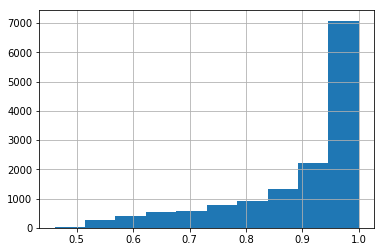

In [67]:
df['vendor_score'].hist()

# 5. Consider the three fields: amount, bill_date, vendor (we are not including invoice_number, as that is an optional field). 
What is the overall % of documents where 
 1. All fields are incorrect
 2. 1 field is correct
 3. 2 fields are correct
 4. All 3 fields are correct

In [68]:
amount_corr = (df['amount'] == df['amount_label'])

In [69]:
bill_corr = (df.bill_date.astype('str') == df.bill_date_label.astype('str'))

In [70]:
vendor_corr = (df['vendor_clean'] == df['vendor_label_clean'])

All fields are incorrect - 1.45 % of them

In [71]:
incorr_3 = (len(df[~amount_corr & ~bill_corr & ~vendor_corr]) / len(df)) * 100

In [72]:
incorr_3

1.4497639919082939

All 3 fields are correct - 44.8% of them

In [73]:
corr_3 = (len(df[amount_corr & bill_corr & vendor_corr]) / len(df)) * 100

In [74]:
corr_3

44.80107889413351

2 fields are correct - 40.32% of them

In [75]:
corr_2 = ( (len(df[amount_corr & bill_corr & ~vendor_corr]) + len(df[amount_corr & ~bill_corr & vendor_corr]) + len(df[~amount_corr & bill_corr & vendor_corr]) ) / len(df) ) * 100

In [76]:
corr_2

40.32366824005395

1 field is correct - 13.43% of them

In [77]:
corr_1 = ( (len(df[amount_corr & ~bill_corr & ~vendor_corr]) + len(df[~amount_corr & ~bill_corr & vendor_corr]) + len(df[~amount_corr & bill_corr & ~vendor_corr]) ) / len(df) ) * 100

In [78]:
corr_1

13.425488873904248

# How do results in #5 differ between different extractors, and different doc_types? 

In [79]:
incorr_3_ext = ( df[~amount_corr & ~bill_corr & ~vendor_corr].groupby('extractor')['id'].count() / len(df) ) * 100
incorr_3_doc = ( df[~amount_corr & ~bill_corr & ~vendor_corr].groupby('doc_type')['id'].count() / len(df) ) * 100

All fields are incorrect - human 0.78%, model 0.67

In [80]:
incorr_3_ext 

extractor
human    0.782198
model    0.667566
Name: id, dtype: float64

All fields are incorrect - pdf 0.28%, png 1.17%

In [81]:
incorr_3_doc

doc_type
pdf    0.276467
png    1.173297
Name: id, dtype: float64

In [83]:
corr_3_ext = ( df[amount_corr & bill_corr & vendor_corr].groupby('extractor')['id'].count() / len(df) ) * 100
corr_3_doc = ( df[amount_corr & bill_corr & vendor_corr].groupby('doc_type')['id'].count() / len(df) ) * 100

All 3 fields are correct - human 14.9%, model 29.9%

In [84]:
corr_3_ext

extractor
human    14.888739
model    29.912340
Name: id, dtype: float64

All 3 fields are correct - pdf 34.7%, png 10.1%

In [85]:
corr_3_doc

doc_type
pdf    34.679703
png    10.121376
Name: id, dtype: float64

In [86]:
frames = [df[amount_corr & bill_corr & ~vendor_corr],df[amount_corr & ~bill_corr & vendor_corr] ,df[~amount_corr & bill_corr & vendor_corr] ]

In [87]:
corr_2_dfs = pd.concat(frames)

In [88]:
corr_2_ext = ( corr_2_dfs.groupby('extractor')['id'].count() / len(df) ) * 100
corr_2_doc = ( corr_2_dfs.groupby('doc_type')['id'].count() / len(df) ) * 100

2 fields are correct - human 17.6%, model 22.7%

In [89]:
corr_2_ext

extractor
human    17.646662
model    22.677006
Name: id, dtype: float64

2 fields are correct - pdf 28.2%, png 12.1%

In [90]:
corr_2_doc

doc_type
pdf    28.179366
png    12.144302
Name: id, dtype: float64

In [91]:
frames = [df[amount_corr & ~bill_corr & ~vendor_corr], df[~amount_corr & ~bill_corr & vendor_corr], df[~amount_corr & bill_corr & ~vendor_corr] ]

In [92]:
corr_1_dfs = pd.concat(frames)

In [93]:
corr_1_ext = ( corr_1_dfs.groupby('extractor')['id'].count() / len(df) ) * 100
corr_1_doc = ( corr_1_dfs.groupby('doc_type')['id'].count() / len(df) ) * 100

1 field is correct - human 5.5%, model 8%

In [94]:
corr_1_ext

extractor
human    5.468645
model    7.956844
Name: id, dtype: float64

1 field is correct - pdf 9%, png 4.5%

In [95]:
corr_1_doc

doc_type
pdf    8.961564
png    4.463924
Name: id, dtype: float64